In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [5]:
df = load_pkl('../../data/feat_engin/lgbm/data_15min_1hour_1day.pkl')

In [6]:
df.shape

(2362117, 1712)

In [7]:
df.head()

,time,close,volume,ticker,tmos_close,index_1hour,index_1day,result,delta_time,income_rate,...,tmos_close_1day_w10_min/tmos_close_1day_w10_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w30_min/close_1day_w30_max,tmos_close_1day_w30_min/tmos_close_1day_w30_max,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max
0,2022-05-04 10:00:00,31.520000,165423.0,AFLT,4.30,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-04 10:15:00,31.920000,99825.0,AFLT,4.32,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-04 10:30:00,32.400002,171391.0,AFLT,4.29,NaN,NaN,WIN,0 days 00:45:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04 10:45:00,32.099998,66741.0,AFLT,4.27,0.0,NaN,WIN,0 days 00:30:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-04 11:00:00,31.940001,42552.0,AFLT,4.25,0.0,NaN,WIN,0 days 00:15:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['result'].value_counts(normalize=True)

result
DNF     0.487526
LOSE    0.407979
WIN     0.104495
Name: proportion, dtype: float64

In [9]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.994000
0.01    0.994000
0.10    0.994000
0.20    0.994000
0.30    0.994000
0.40    0.994000
0.50    0.997773
0.60    0.999747
0.70    1.001901
0.80    1.005115
0.90    1.014000
0.99    1.014000
1.00    1.014000
Name: income_rate, dtype: float64

In [10]:
#распределение времени в часах
(df['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       4.0
0.50       4.0
0.60       4.0
0.70       4.0
0.80      13.0
0.90      16.0
0.99      65.0
1.00    6734.0
Name: delta_time, dtype: float64

## CHANGE TARGET

In [14]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    #макс выигрыш и потери
    # if percent_first < percent_second:  
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    # else:
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [19]:
inds = np.arange(df.shape[0])
inds.shape

(2362117,)

In [25]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=1.005, percent_second=0.985, points_to_wait=4*4*1)

python(50474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|█████████████████████████████████████████████████████████████| 2362117/2362117 [09:26<00:00, 4168.57it/s]


In [28]:
dump_pkl(df_result, '../../data/feat_engin/lgbm/df_result_+0.5_-1.5_4hour.pkl')

In [30]:
df_result = load_pkl('../../data/feat_engin/lgbm/df_result_+0.5_-1.5_4hour.pkl')
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 00:15:00,0.986310,31.920000,1
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 00:15:00,0.983962,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,WIN,AFLT,0 days 00:45:00,1.032951,31.299999,5
3,3,2022-05-04 10:45:00,32.099998,WIN,AFLT,0 days 00:30:00,1.023922,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,WIN,AFLT,0 days 00:15:00,1.019038,31.299999,5
...,...,...,...,...,...,...,...,...,...
2362112,2362112,2025-02-17 22:45:00,396.179993,DNF,BSPB,0 days 01:00:00,0.995517,397.559998,2362116
2362113,2362113,2025-02-17 23:00:00,397.089996,DNF,BSPB,0 days 00:45:00,0.997816,397.559998,2362116
2362114,2362114,2025-02-17 23:15:00,397.519989,DNF,BSPB,0 days 00:30:00,0.998899,397.559998,2362116
2362115,2362115,2025-02-17 23:30:00,396.480011,DNF,BSPB,0 days 00:15:00,0.996276,397.559998,2362116


In [33]:
df_result['result'].value_counts(normalize=True)


result
DNF     0.487610
LOSE    0.407888
WIN     0.104502
Name: proportion, dtype: float64

In [35]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.495012
0.01    0.975703
0.10    0.990030
0.20    0.992248
0.30    0.993299
0.40    0.993956
0.50    0.997774
0.60    0.999747
0.70    1.001901
0.80    1.005116
0.90    1.014148
0.99    1.024332
1.00    1.289503
Name: income_rate, dtype: float64

In [37]:
#распределение времени в часах
(df_result['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       4.0
0.50       4.0
0.60       4.0
0.70       4.0
0.80      13.0
0.90      16.0
0.99      65.0
1.00    6734.0
Name: delta_time, dtype: float64

In [40]:
(df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True)

In [42]:
df_result.head()

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 00:15:00,0.986310,31.920000,1
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 00:15:00,0.983962,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,WIN,AFLT,0 days 00:45:00,1.032951,31.299999,5
3,3,2022-05-04 10:45:00,32.099998,WIN,AFLT,0 days 00:30:00,1.023922,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,WIN,AFLT,0 days 00:15:00,1.019038,31.299999,5


In [45]:
df[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]

In [48]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3676
cols = ['ticker', 'time', 'close', 'close_1hour', 'close_1day', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask, cols].iloc[i:i+10]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
250910,FEES,2025-02-03 22:00:00,0.07816,0.07820,0.07898,DNF,0 days 14:00:00,1.003862,0.07778,250926
250911,FEES,2025-02-03 22:15:00,0.07828,0.07820,0.07898,DNF,0 days 14:00:00,1.005132,0.07780,250927
250912,FEES,2025-02-03 22:30:00,0.07830,0.07820,0.07898,DNF,0 days 14:00:00,1.005386,0.07780,250928
250913,FEES,2025-02-03 22:45:00,0.07824,0.07824,0.07898,DNF,0 days 14:00:00,1.005902,0.07770,250929
250914,FEES,2025-02-03 23:00:00,0.07816,0.07824,0.07898,DNF,0 days 14:00:00,1.008724,0.07740,250930
250915,FEES,2025-02-03 23:15:00,0.07812,0.07824,0.07898,DNF,0 days 14:00:00,1.005400,0.07762,250931
250916,FEES,2025-02-03 23:30:00,0.07804,0.07824,0.07898,DNF,0 days 14:00:00,1.006688,0.07744,250932
250917,FEES,2025-02-03 23:45:00,0.07802,0.07802,0.07802,DNF,0 days 14:00:00,1.006434,0.07744,250933
250918,FEES,2025-02-04 10:00:00,0.07810,0.07802,0.07802,DNF,0 days 04:00:00,1.009499,0.07728,250934
250919,FEES,2025-02-04 10:15:00,0.07824,0.07802,0.07802,DNF,0 days 04:00:00,1.009481,0.07742,250935


In [50]:
i = 491081
df[cols].iloc[i:i+1]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
491081,SGZH,2024-10-18 14:30:00,1.683,1.674,1.682,LOSE,0 days 00:45:00,0.990681,1.697,491084


### 1. train/valid/test/test2 split

In [13]:
df['target'] = (df['result'] == 'WIN').astype(int)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/162261981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['result'] == 'WIN').astype(int)


<Axes: xlabel='time'>

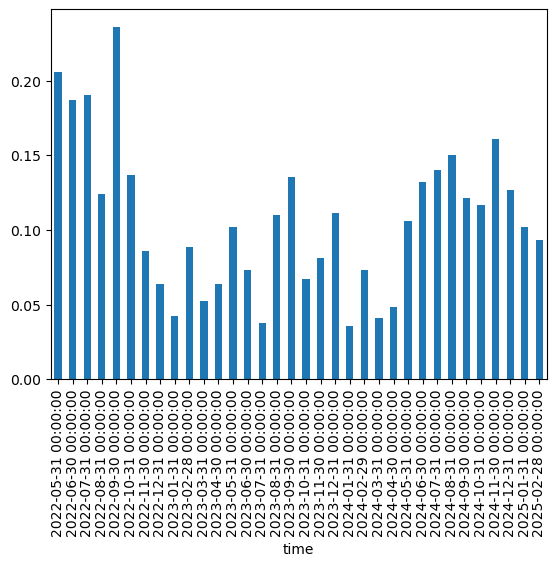

In [14]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

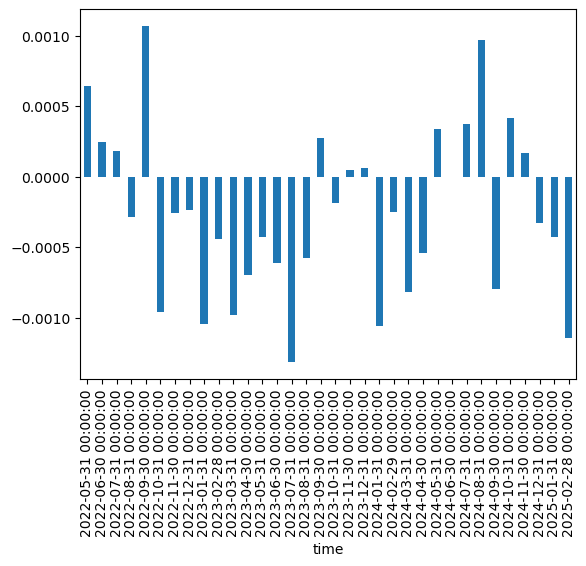

In [15]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [17]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
SBERP    0.044070
SBER     0.045991
LKOH     0.046833
IRAO     0.050658
GAZP     0.056366
TATNP    0.056665
MTSS     0.057640
PHOR     0.057791
SNGSP    0.059763
MOEX     0.059820
TATN     0.061430
ROSN     0.064590
TRNFP    0.067197
GMKN     0.067425
SIBN     0.068672
RTKM     0.068731
HYDR     0.068794
MGNT     0.072903
NVTK     0.074706
ALRS     0.078613
CHMF     0.080480
VTBR     0.081134
BELU     0.082711
PLZL     0.084744
MAGN     0.086845
AFLT     0.088788
UPRO     0.088848
POSI     0.091480
SNGS     0.091578
NLMK     0.091749
RUAL     0.091944
X5       0.094939
T        0.100553
BANEP    0.100916
BSPB     0.101783
FEES     0.102747
YDEX     0.104600
PIKK     0.107051
FLOT     0.107439
AFKS     0.107545
VSMO     0.111607
ENPG     0.112888
SELG     0.119451
MVID     0.119714
SGZH     0.122145
MDMG     0.122380
SMLT     0.124455
LSRG     0.129419
VKCO     0.131331
NMTP     0.133449
TRMK     0.134162
RASP     0.136121
WUSH     0.136679
FESH     0.145258
MTLR     0.146112
SFI

In [18]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
IRAO     0.999223
SBER     0.999244
SBERP    0.999247
MOEX     0.999256
TATN     0.999278
TATNP    0.999278
SNGSP    0.999291
LKOH     0.999296
CHMF     0.999393
ROSN     0.999395
X5       0.999418
MTSS     0.999444
PHOR     0.999448
RTKM     0.999489
SIBN     0.999493
POSI     0.999512
PLZL     0.999532
ALRS     0.999534
YDEX     0.999550
TRNFP    0.999565
MGNT     0.999568
BELU     0.999574
AFLT     0.999583
NLMK     0.999584
NVTK     0.999598
SNGS     0.999607
GMKN     0.999617
MAGN     0.999623
GAZP     0.999625
HYDR     0.999643
BSPB     0.999644
AFKS     0.999655
BANEP    0.999662
VTBR     0.999681
MDMG     0.999689
PIKK     0.999721
LSRG     0.999739
UPRO     0.999768
RUAL     0.999804
FEES     0.999815
FLOT     0.999818
SFIN     0.999840
T        0.999843
MVID     0.999857
SELG     0.999935
ENPG     0.999964
RASP     0.999969
VKCO     1.000020
NMTP     1.000026
MTLR     1.000029
SMLT     1.000072
FESH     1.000072
SGZH     1.000089
HEAD     1.000114
MTLRP    1.000118
WUS

In [21]:
df['time'].max()

Timestamp('2025-02-17 23:45:00')

In [22]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test3 = np.array((pd.Timestamp('2025-01-01') <= df['time']))# & (df['time'] < pd.Timestamp('2025-03-01')))

In [23]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1759268, 162196, 161173, 157454)

In [24]:
mask_test3.sum()

122026

In [26]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 122
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all

mask_test3 &= mask_avbl_all


#мб дату неправильно обрезаю

In [27]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [28]:
mask_test3.sum()

122026

In [38]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

1926950

In [ ]:
# for col in tqdm(df.columns):
#     assert df.loc[mask_data, col].isnull().sum() == 0, f'Nulls {col}'

In [41]:
df.loc[mask_train, 'ticker'].nunique()

67

In [43]:
#Гуд

In [46]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7504745841874465,
 0.08417239679285918,
 0.0836415060069021,
 0.08171151301279224)

In [49]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.07768819750962398,
 0.14513921428395274,
 0.11918249334565963,
 0.14357844195765113)

In [51]:
df.loc[mask_test3, 'target'].mean()

0.0990198810089653

In [54]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9995591, 1.0006684, 0.99984294, 0.99991465)

In [56]:
df.loc[mask_test3, 'income_rate'].mean()

0.9993379

In [60]:
#проверки

In [62]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [67]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/153766446.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_code'] = df['ticker'].astype('category').cat.codes


In [69]:
df['ticker_code'].nunique()

67

In [71]:
df.loc[mask_train, 'ticker_code'].nunique()

67

In [73]:
df.shape

(2362117, 1714)

In [75]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',

 'ticker',

 'index_1hour',
 'index_1day',
    
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',

'time_1hour',
 'close_1hour',
 'volume_1hour',
 'tmos_close_1hour',

'time_1day',
 'close_1day',
 'volume_1day',
 'tmos_close_1day',
    
             'target',
             'y_pred']


features = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [77]:
len(features), len(cat_features)

(1693, 4)

### Get stability features

In [81]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [84]:
#subsample_train

coeff_subsample = 0.2

inds_train = np.argwhere(mask_train).ravel()
inds_train_subsample = np.random.RandomState(seed=42).permutation(inds_train)[:int(len(inds_train)*coeff_subsample)]

mask_train_subsample = np.zeros_like(mask_train).astype(bool)
mask_train_subsample[inds_train_subsample] = True

mask_train_subsample.sum()

289225

In [87]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 4)
    
    return 'mean_income_rate', score, True#is_higher_better

In [ ]:



params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
    # "metric": "auc",
    "metric": "mean_income_rate",    
    "early_stopping" : 10, 
    
    
}

auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

                
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],

           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train_subsample, stab_features], label=df.loc[mask_train_subsample, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)

    D_train.income_rate = df.loc[mask_train_subsample, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
    
    D_train.time = df.loc[mask_train_subsample, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values


    
    model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


    threshold1 = np.quantile(y_pred_valid, q=0.99)
    threshold2 = np.quantile(y_pred_valid, q=0.95)
    
    auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]


    auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]

    
    auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
   
    auc_features['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
    auc_features['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
    auc_features['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
    auc_features['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]

auc_features_cp = auc_features.copy()

In [151]:
dump_pkl(auc_features, 'auc_features__+0.5_-1_4hour.pkl')

In [126]:
auc_features = load_pkl('auc_features__+0.5_-1.5_4hour.pkl')

In [128]:
pd.set_option('display.max_columns', 100)
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,close_w1_roc,0.537887,0.520434,0.531324,0.516276,0.001524,0.001865,0.001717,0.000743,0.001889,0.002540,0.002347,0.001718,0.041473,0.055883,0.051629,0.037805,0.000818,0.001342,0.000934,0.000412,0.000885,0.001719,0.001389,0.000908,0.019475,0.037826,0.030557,0.019977
1,volume_w1_roc,0.513741,0.501696,0.502644,0.502917,0.000026,0.001226,0.000419,-0.000212,0.000054,0.001164,0.000280,-0.000094,0.001185,0.025600,0.006155,-0.002061,-0.000213,0.000768,0.000053,-0.000045,-0.000230,0.000784,-0.000033,-0.000004,-0.005071,0.017238,-0.000716,-0.000091
2,tmos_close_w1_roc,0.511584,0.501031,0.516204,0.513959,-0.000132,0.000140,0.000418,0.000572,-0.000807,0.000107,-0.000256,0.000181,-0.008150,0.002149,-0.005642,0.003705,-0.000132,0.000140,0.000418,0.000572,-0.000807,0.000107,-0.000256,0.000181,-0.008150,0.002149,-0.005642,0.003705
3,close_w5_norm_std,0.655995,0.575845,0.610467,0.548199,0.000929,0.001491,0.000835,0.000098,0.001026,0.001609,0.001203,0.000784,0.021957,0.035396,0.026459,0.017243,0.000253,0.000823,0.000211,-0.000003,0.000157,0.000779,0.000351,0.000178,0.003446,0.017145,0.007718,0.003906
4,close_w5_mean_abs_pct,0.664959,0.583410,0.621233,0.548813,0.001324,0.001283,0.000640,-0.000225,0.001513,0.002119,0.001173,0.000855,0.031238,0.045576,0.025230,0.017928,0.000395,0.000725,0.000418,-0.000107,0.000351,0.000745,0.000606,0.000040,0.007712,0.016399,0.013323,0.000870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,close_1day_w60_min/close_1day_w60_max,0.559668,0.518328,0.527353,0.517949,0.001033,0.001004,-0.000213,0.000137,0.000824,0.001036,0.000161,0.000280,0.017548,0.022802,0.003537,0.006149,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
1689,tmos_close_1day_w60_min/tmos_close_1day_w60_max,0.522779,0.500000,0.500000,0.500000,-0.000403,0.000669,-0.000157,-0.000085,-0.000439,0.000674,-0.000162,-0.000102,-0.009513,0.014826,-0.003566,-0.002243,-0.000403,0.000669,-0.000157,-0.000085,-0.000439,0.000674,-0.000162,-0.000102,-0.009513,0.014826,-0.003566,-0.002243
1690,close_1day_w120_min/close_1day_w120_max,0.584246,0.540044,0.558287,0.541055,0.000541,0.001017,0.000144,0.000113,0.000441,0.001368,0.000120,0.000256,0.009679,0.030099,0.002640,0.005640,0.000541,0.001017,0.000144,0.000113,0.000441,0.001368,0.000120,0.000256,0.009679,0.030099,0.002640,0.005640
1691,tmos_close_1day_w120_min/tmos_close_1day_w120_max,0.515716,0.500000,0.500000,0.500000,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243


#### auc <=0.525

In [132]:
auc_treshold = 0.51

In [134]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

139

In [136]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

538

In [138]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

578

In [140]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

765

In [143]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

755

In [145]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

989

#### delta_auc > 0.05

In [150]:
auc_delta_treshold  = 0.02

In [152]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

764

In [154]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

871

In [156]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

1087

In [159]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

1029

In [161]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

1247

#### union criterias

In [167]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

1399

In [169]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

1559

In [172]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(294,
 array(['close_w1_roc', 'volume_w5_alpha', 'volume_w5_rsi',
        'volume_w5_roc', 'volume_w10_norm_std', 'volume_w10_mean_abs_pct',
        'volume_w10_alpha', 'volume_w10_roc', 'tmos_close_w10_roc',
        'volume_w20_norm_std', 'volume_w20_mean_abs_pct', 'volume_w20_roc',
        'close_w30_rsi', 'close_w30_lvl_1.03-1.04',
        'close_w30_lvl_1.04-1.05', 'tmos_close_w30_lvl_1.01-1.015',
        'tmos_close_w30_lvl_1.015-1.02', 'close_w120_rsi',
        'close_w120_lvl_1.005-1.01', 'tmos_close_w120_lvl_1.02-1.03',
        'tmos_close_w120_lvl_1.03-1.04', 'volume_1hour_w1_roc',
        'volume_1hour_w5_norm_std', 'volume_1hour_w5_roc',
        'volume_1hour_w10_mean_abs_pct', 'tmos_close_1hour_w10_rsi',
        'volume_1hour_w20_mean_abs_pct', 'volume_1hour_w20_alpha',
        'volume_1hour_w20_rsi', 'volume_1hour_w20_roc',
        'close_1hour_w30_rsi', 'close_1hour_w30_lvl_1.005-1.01',
        'close_1hour_w30_lvl_-0.98-0.99', 'close_1hour_w30_lvl_1.05-1.07',
        'tm

In [174]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1241,close_1hour_w120_ma_up_2std/close,0.605875,0.616999,0.588744,0.578081,0.000771,0.000838,-0.000268,0.000264,0.000563,0.000797,-0.000147,0.000021,0.010426,0.017537,-0.003085,0.000459,0.000771,0.000838,-0.000268,0.000264,0.000563,0.000797,-0.000147,0.000021,0.010426,0.017537,-0.003085,0.000459
1630,close_1day_w10_ma_up_2std/close,0.605129,0.610999,0.591225,0.580231,0.000696,0.000665,-0.000197,0.000156,0.000543,0.000836,0.000339,-0.000032,0.009135,0.018381,0.006958,-0.000680,0.000696,0.000665,-0.000197,0.000156,0.000543,0.000836,0.000339,-0.000032,0.009135,0.018381,0.006958,-0.000680
1603,close_1day_w10_max/close,0.592725,0.605019,0.575871,0.578224,0.000509,0.000752,-0.000299,0.000199,0.000290,0.000745,-0.000310,0.000060,0.005426,0.016383,-0.006670,0.001310,0.000509,0.000752,-0.000299,0.000199,0.000290,0.000745,-0.000310,0.000060,0.005426,0.016383,-0.006670,0.001310
1607,close_1day_w120_max/close,0.576935,0.596198,0.586208,0.578705,0.001330,0.001677,0.000107,0.000183,0.001419,0.001473,0.000071,0.000163,0.011973,0.032414,0.001556,0.003593,0.000594,0.001133,-0.000028,0.000156,0.000758,0.000902,0.000043,0.000119,0.010472,0.019849,0.000944,0.002616
1672,close_1day_w120_ma_up_3std/close,0.598174,0.594110,0.581322,0.573738,0.001177,0.001637,0.000076,0.000341,0.001212,0.001592,0.000105,0.000184,0.010959,0.035034,0.002301,0.004054,0.000639,0.000928,-0.000112,0.000136,0.000684,0.000865,0.000019,0.000098,0.013748,0.019031,0.000427,0.002152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,close/close_w5_expma,0.521750,0.510381,0.515992,0.511356,0.001633,0.001821,0.001733,0.000641,0.002347,0.003635,0.003021,0.002667,0.051043,0.079970,0.066461,0.058665,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
550,volume_w5_std/volume_w20_std,0.515907,0.510349,0.520481,0.498255,-0.000033,0.001190,0.000533,0.000146,0.000008,0.001338,0.000573,0.000310,0.000186,0.029438,0.012600,0.006823,-0.000206,0.001027,0.000355,-0.000206,-0.000250,0.001085,0.000335,-0.000125,-0.005490,0.023876,0.007370,-0.002742
522,tmos_close_w5_mean_abs_pct/tmos_close_w60_mean...,0.525362,0.510300,0.515216,0.518389,-0.000284,0.000790,-0.000524,-0.000381,-0.000331,0.000955,-0.000212,-0.000849,-0.006926,0.021006,-0.004662,-0.018251,-0.000284,0.000790,-0.000524,-0.000381,-0.000331,0.000955,-0.000212,-0.000849,-0.006926,0.021006,-0.004662,-0.018251
459,close_w5_roc/close_w10_roc,0.512954,0.510280,0.512736,0.514650,-0.000460,0.000874,-0.000031,0.000005,-0.000509,0.000864,-0.000047,0.000040,-0.011190,0.018999,-0.001042,0.000874,-0.000460,0.000874,-0.000031,0.000005,-0.000509,0.000864,-0.000047,0.000040,-0.011190,0.018999,-0.001042,0.000874


In [177]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(134,
 array(['volume_w5_alpha', 'volume_w5_rsi', 'volume_w5_roc',
        'volume_w10_norm_std', 'volume_w10_alpha', 'volume_w10_roc',
        'volume_w20_norm_std', 'volume_w20_mean_abs_pct', 'volume_w20_roc',
        'close_w120_rsi', 'tmos_close_w120_lvl_1.03-1.04',
        'volume_1hour_w1_roc', 'volume_1hour_w5_norm_std',
        'volume_1hour_w5_roc', 'volume_1hour_w20_mean_abs_pct',
        'volume_1hour_w20_rsi', 'close_1hour_w30_rsi',
        'close_1hour_w30_lvl_-0.98-0.99', 'close_1hour_w30_lvl_1.05-1.07',
        'tmos_close_1hour_w30_lvl_1.03-1.04', 'close_1hour_w60_rsi',
        'close_1hour_w120_lvl_-0.97-0.98', 'close_1day_w5_rsi',
        'volume_1day_w5_rsi', 'tmos_close_1day_w30_lvl_1.015-1.02',
        'close_1day_w120_lvl_1.05-1.07', 'close_w5_alpha/close_w120_alpha',
        'close_w10_alpha/close_w120_alpha',
        'volume_w5_alpha/volume_w10_alpha',
        'tmos_close_w1_roc/tmos_close_w10_alpha',
        'tmos_close_w20_alpha/tmos_close_w120_alpha',
       

In [179]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
1603,close_1day_w10_max/close,0.592725,0.605019,0.575871,0.578224,5.089155e-04,0.000752,-0.000299,0.000199,0.000290,0.000745,-3.102180e-04,0.000060,0.005426,0.016383,-0.006670,0.001310,5.089155e-04,0.000752,-0.000299,0.000199,0.000290,0.000745,-3.102180e-04,0.000060,0.005426,0.016383,-0.006670,0.001310
1607,close_1day_w120_max/close,0.576935,0.596198,0.586208,0.578705,1.330248e-03,0.001677,0.000107,0.000183,0.001419,0.001473,7.070944e-05,0.000163,0.011973,0.032414,0.001556,0.003593,5.943404e-04,0.001133,-0.000028,0.000156,0.000758,0.000902,4.292109e-05,0.000119,0.010472,0.019849,0.000944,0.002616
1602,close_1day_w5_max/close,0.584734,0.593085,0.565144,0.569279,1.859975e-04,0.000917,-0.000135,0.000310,-0.000114,0.000627,-2.772726e-04,-0.000160,-0.002430,0.013797,-0.006100,-0.003519,1.859975e-04,0.000917,-0.000135,0.000310,-0.000114,0.000627,-2.772726e-04,-0.000160,-0.002430,0.013797,-0.006100,-0.003519
1670,close_1day_w120_ma_up_2std/close,0.586209,0.590545,0.581137,0.572612,8.238765e-04,0.001722,-0.000017,0.000334,0.001123,0.001550,-5.785628e-05,0.000202,0.020820,0.034110,-0.001273,0.004446,8.238765e-04,0.001722,-0.000017,0.000334,0.001123,0.001550,-5.785628e-05,0.000202,0.020820,0.034110,-0.001273,0.004446
1604,close_1day_w20_max/close,0.586146,0.589689,0.584325,0.569495,8.283295e-04,0.000769,-0.000274,0.000134,0.000779,0.000732,3.630505e-05,0.000025,0.011504,0.016100,0.000762,0.000536,8.283295e-04,0.000769,-0.000274,0.000134,0.000779,0.000732,3.630505e-05,0.000025,0.011504,0.016100,0.000762,0.000536
1243,close_1hour_w120_ma_up_3std/close,0.572007,0.581526,0.559778,0.560176,5.810967e-04,0.000812,-0.000228,0.000167,0.000466,0.000941,9.899275e-05,-0.000207,0.010022,0.020701,0.002178,-0.004553,5.810967e-04,0.000812,-0.000228,0.000167,0.000466,0.000941,9.899275e-05,-0.000207,0.010022,0.020701,0.002178,-0.004553
1071,close_1hour_w5_ma/close_1hour_w60_ma,0.573431,0.577748,0.558074,0.556569,3.210566e-04,0.000943,-0.000092,0.000284,0.000279,0.000738,7.927242e-06,-0.000287,0.005554,0.016233,0.000159,-0.006169,3.210566e-04,0.000943,-0.000092,0.000284,0.000279,0.000738,7.927242e-06,-0.000287,0.005554,0.016233,0.000159,-0.006169
226,close_1hour_w60_rsi,0.570944,0.577295,0.563353,0.556416,1.126650e-04,0.001691,0.000606,0.000990,0.000055,0.000605,-4.234640e-04,0.000137,0.000951,0.012420,-0.006987,0.002520,1.126650e-04,0.001691,0.000606,0.000990,0.000055,0.000605,-4.234640e-04,0.000137,0.000951,0.012420,-0.006987,0.002520
1155,tmos_close_1hour_w30_expma/tmos_close_1hour_w6...,0.555598,0.573995,0.570637,0.539297,-3.725965e-05,0.000788,-0.000054,-0.000079,0.000297,0.000998,-3.346729e-04,-0.000538,0.001341,0.018046,-0.003012,-0.005781,-3.725965e-05,0.000788,-0.000054,-0.000079,0.000297,0.000998,-3.346729e-04,-0.000538,0.001341,0.018046,-0.003012,-0.005781
1150,tmos_close_1hour_w10_expma/tmos_close_1hour_w6...,0.566644,0.566709,0.553520,0.546921,-1.268036e-04,0.000764,-0.000327,0.000082,0.000049,0.000905,-7.420736e-04,-0.000237,0.000297,0.016808,-0.007792,-0.002787,-1.268036e-04,0.000764,-0.000327,0.000082,0.000049,0.000905,-7.420736e-04,-0.000237,0.000297,0.016808,-0.007792,-0.002787


### mask3

#### #1

In [418]:
col = 'mir_month@1'
threshold = 0.07
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir_train = df_auc_features[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc_features[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc_features[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc_features[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(0, 38, 33, 7)

In [420]:
(mask_ir_valid&mask_ir_test&mask_ir_test2).sum(), (mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(7, 0)

In [422]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

7

#### #2

In [426]:
col = 'mir_month@1'
threshold = 0.01
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir2_test = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(327, 235)

In [428]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

129

In [431]:
(mask_ir&mask_ir2).sum()

0

In [435]:
mask_criteria3 = mask_ir#&mask_ir2
features_criteria3 = df_auc_features['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(7,
 array(['close/close_w10_ma', 'close/close_w20_ma', 'close/close_w30_ma',
        'close/close_w10_expma', 'close/close_w20_expma',
        'close/close_w30_expma', 'close/close_1hour_w5_expma'],
       dtype=object))

In [437]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
683,close/close_w20_expma,0.585956,0.551051,0.548718,0.533107,0.001603,0.001224,0.002117,0.000302,0.002337,0.004950,0.004203,0.003793,0.047667,0.104059,0.092477,0.073752,-0.000184,0.000479,-0.000175,-0.000086,-0.000594,-0.000537,-0.000683,-0.000586,-0.013009,-0.011815,-0.015036,-0.012901
682,close/close_w10_expma,0.567801,0.537427,0.545479,0.530460,0.001757,0.001652,0.002259,0.000448,0.002431,0.004727,0.004055,0.004043,0.051286,0.103991,0.089209,0.086884,-0.000319,0.000494,-0.000093,-0.000115,-0.000781,-0.000214,-0.000527,-0.000502,-0.017185,-0.004717,-0.011599,-0.011034
1110,close/close_1hour_w5_expma,0.525089,0.507983,0.517893,0.512201,0.001167,0.000769,0.001560,0.000289,0.001952,0.004476,0.003703,0.003392,0.041970,0.098474,0.081462,0.072891,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
634,close/close_w10_ma,0.518555,0.507810,0.512825,0.509299,0.001760,0.001655,0.002052,0.000386,0.002466,0.004471,0.003702,0.003593,0.052141,0.098361,0.081439,0.077217,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
635,close/close_w20_ma,0.522530,0.507105,0.515306,0.511482,0.001357,0.000700,0.001729,0.000294,0.002118,0.004579,0.004098,0.004018,0.044474,0.100734,0.090150,0.084286,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
684,close/close_w30_expma,0.523648,0.506800,0.514322,0.511771,0.001310,0.001056,0.001504,0.000272,0.002256,0.004679,0.004149,0.003628,0.046469,0.093794,0.089205,0.070537,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243
636,close/close_w30_ma,0.525321,0.506460,0.517370,0.512505,0.000923,0.000271,0.001436,0.000249,0.001834,0.004576,0.004084,0.003558,0.038601,0.096196,0.087810,0.070993,-0.000462,0.000669,-0.000157,-0.000085,-0.000494,0.000674,-0.000162,-0.000102,-0.010872,0.014826,-0.003566,-0.002243


### model

In [444]:
features = features_criteria3.tolist()
#features = ['close/close_w30_expma']
cat_features = [feature for feature in features if feature in cat_features_all]

In [446]:
len(features), len(cat_features)

(7, 0)

In [448]:
'ticker_code' in features

False

In [450]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [451]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [1400]:



# def mean_income_rate(y_pred, data):
#     q = 0.98
#     mask = y_pred >= np.quantile(y_pred, q)
#     score = round(data.income_rate[mask].mean(), 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

# def mean_income_rate(y_pred, D_sample):
#     q = 0.99
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     df_sup = pd.DataFrame({'time' : D_sample.time,
#                            'income_rate' : D_sample.income_rate,
#                            'y_pred' : y_pred})
#     #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
#     score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
#     score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
#     score = round(score, 4)
    
#     return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1000,

    
    "num_leaves": 5,
    #"learning_rate": 0.001,
     "feature_fraction": 0.3,
     "bagging_fraction": 0.3,
     "bagging_freq": 1,
     'lambda_l1' : 100,
     'lambda_l2' : 100,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    #"metric": "auc",
     "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 112350, number of negative: 1333777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1446127, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077690 -> initscore=-2.474151
[LightGBM] [Info] Start training from score -2.474151
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's mean_income_rate: 0.1104


In [1402]:
model.num_trees()

31

In [1405]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6650040233124443, 0.598538686873779, 0.6007133801164246, 0.5556011686455231)

In [1408]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.538415
WIN     0.297561
DNF     0.164024
Name: proportion, dtype: float64
1.001311897814068

Test
result
LOSE    0.508832
WIN     0.332764
DNF     0.158405
Name: proportion, dtype: float64
1.002220472845854

Test2
result
LOSE    0.632839
WIN     0.258837
DNF     0.108324
Name: proportion, dtype: float64
1.0002322310008611


In [1411]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.21119118089503547

Valid
result
LOSE    0.538415
WIN     0.297561
DNF     0.164024
Name: proportion, dtype: float64
1.001311897814068

Test
result
LOSE    0.509601
WIN     0.325948
DNF     0.164451
Name: proportion, dtype: float64
1.002122239417011

Tetst2
result
LOSE    0.592670
WIN     0.240967
DNF     0.166363
Name: proportion, dtype: float64
1.0003786701036688


In [1414]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0013118978140680415, 0.0021222394170110626, 0.00037867010366876563)

In [1416]:
#(0.00519963161109227, 0.004548106594387313, 0.005202952029520258)

In [1418]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0006685216748727, 0.9998432210640462, 0.9999153494203294)

In [1420]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.005253007475736961, 0.004231930018761249, 0.0038341807745887525)

In [1422]:
#(0.004938866300974756, 0.006170416911948592, 0.0044445648451688635)

In [1424]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.110429890489937, 0.09098649540336684, 0.0765052815022593)

In [1426]:
#(0.06822526936695361, 0.06629610728651743, 0.06960640537179712)

In [1428]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1430]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1640, 2031, 3847)

In [1432]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 43, 39)

In [1434]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG',
       'NMTP', 'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN',
       'TGKN', 'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS',
       'VSMO', 'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN',
       'SNGS', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX',
       'SBERP', 'CHMF', 'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU',
       'FLOT', 'PIKK', 'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER',
       'BANEP', 'BSPB'], dtype=object)

In [1436]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_26813/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
IRAO,1.0,1.000773
PLZL,2.0,1.004000
MDMG,10.0,0.994900
SNGSP,14.0,0.998286
LKOH,18.0,0.998298
BELU,31.0,1.001340
SNGS,31.0,1.001690
VTBR,33.0,0.996891
HEAD,33.0,1.000034


In [1439]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close/close_w20_expma', 32.14),
 ('close/close_w10_expma', 31.16),
 ('close/close_w30_ma', 14.63),
 ('close/close_w20_ma', 9.74),
 ('close/close_w10_ma', 8.33),
 ('close/close_w30_expma', 4.0)]

# 3.2 Tuning hyperparams

In [1443]:
top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [1445]:
len(top_features), len(top_cat_features)

(6, 0)

In [1447]:
top_features

['close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma']

In [1450]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1452]:
D_train.data.shape

(1446127, 6)

In [1454]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 1000,
 'num_leaves': 5,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [1470]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*8*8)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.3, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 10,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.99)
                    threshold2 = np.quantile(y_pred_valid, q=0.95)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]


                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████████| 768/768 [21:26<00:00,  1.68s/it]


In [1472]:
dump_pkl(history, './hst_+0.5_-1.5_4hour.pkl')

In [5173]:
history = load_pkl('./hst_+0.5_-1.5_4hour.pkl')

In [1465]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.595958,0.565960,0.557919,0.541213,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000310,0.000771,-0.000192,-0.000008,-0.000897,-0.000536,-0.000898,-0.000764,-0.019731,-0.011792,-0.019755,-0.016798
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.599628,0.568326,0.558729,0.542829,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000309,0.000777,-0.000190,0.000001,-0.000906,-0.000529,-0.000905,-0.000771,-0.019921,-0.011648,-0.019902,-0.016958
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.595958,0.565960,0.557919,0.541213,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000310,0.000771,-0.000192,-0.000008,-0.000897,-0.000536,-0.000898,-0.000764,-0.019731,-0.011792,-0.019755,-0.016798
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.597487,0.566926,0.560111,0.542379,0.001389,0.001185,0.001611,0.000432,0.002497,0.004778,0.004070,0.003697,0.054422,0.100442,0.087509,0.075650,-0.000298,0.000736,-0.000188,0.000002,-0.000837,-0.000557,-0.000864,-0.000706,-0.018418,-0.012260,-0.019002,-0.015523
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.596338,0.566340,0.558555,0.541591,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000298,0.000737,-0.000188,0.000002,-0.000837,-0.000557,-0.000864,-0.000705,-0.018418,-0.012258,-0.019002,-0.015517
5,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.599764,0.568518,0.558956,0.542857,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000310,0.000771,-0.000192,-0.000008,-0.000897,-0.000536,-0.000898,-0.000764,-0.019726,-0.011794,-0.019757,-0.016800
6,"{'boosting_type': 'gbdt', 'objective': 'binary...",8,0.613819,0.574810,0.570069,0.548330,0.001620,0.001531,0.001807,0.000467,0.002576,0.004790,0.004024,0.003724,0.055906,0.100702,0.086517,0.076221,-0.000209,0.000754,-0.000127,-0.000017,-0.000591,-0.000388,-0.000662,-0.000508,-0.012981,-0.008526,-0.014575,-0.011176
7,"{'boosting_type': 'gbdt', 'objective': 'binary...",16,0.632712,0.584353,0.579877,0.550841,0.001522,0.001304,0.001744,0.000545,0.002705,0.004786,0.004141,0.003826,0.058821,0.095942,0.089037,0.074392,-0.000096,0.000643,-0.000097,-0.000082,-0.000297,-0.000258,-0.000430,-0.000374,-0.006533,-0.005677,-0.009466,-0.008227
8,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.595958,0.565960,0.557919,0.541213,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000310,0.000771,-0.000192,-0.000008,-0.000897,-0.000536,-0.000898,-0.000764,-0.019731,-0.011792,-0.019755,-0.016798
9,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.599628,0.568326,0.558729,0.542829,0.001430,0.001254,0.001709,0.000402,0.002514,0.004805,0.004123,0.003700,0.054800,0.101013,0.088655,0.075713,-0.000309,0.000777,-0.000190,0.000001,-0.000906,-0.000529,-0.000905,-0.000771,-0.019921,-0.011648,-0.019902,-0.016958


### threshold delta AUC

In [5190]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(616, 314, 111)

In [5192]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(314, 110)

In [5194]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
556,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.598675,0.595155,0.568773,0.553453,0.002590,0.002006,0.003462,0.002791,0.002823,0.003423,0.003607,0.003319,0.047083,0.068308,0.07567,0.071791,0.001438,0.001394,0.001888,0.001666,0.001659,0.001958,0.002034,0.002011,0.036322,0.043069,0.044758,0.044245
989,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.598320,0.594874,0.568714,0.557406,0.004323,0.003649,NaN,0.001131,0.004323,0.004153,NaN,0.001131,0.000217,0.006374,NaN,0.000422,0.004011,0.003586,NaN,0.001759,0.001106,0.002833,NaN,0.001218,0.000500,0.015946,NaN,0.003179
988,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.598332,0.594549,0.568748,0.557343,0.004323,0.003649,NaN,0.001131,0.004323,0.004153,NaN,0.001131,0.000217,0.006374,NaN,0.000422,0.004011,0.003586,NaN,0.001759,0.001106,0.002833,NaN,0.001218,0.000500,0.015946,NaN,0.003179
181,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.594319,0.586228,0.565859,0.542238,0.002234,0.002304,0.002690,0.002212,0.002579,0.003559,0.003268,0.003478,0.056081,0.078302,0.07189,0.076515,0.001091,0.001205,0.001448,0.001374,0.001299,0.001943,0.002100,0.002131,0.028587,0.042747,0.046205,0.046881
194,"{'boosting_type': 'gbdt', 'objective': 'binary...",3,0.594319,0.586228,0.565859,0.542238,0.002234,0.002304,0.002690,0.002212,0.002579,0.003559,0.003268,0.003478,0.056081,0.078302,0.07189,0.076515,0.001091,0.001205,0.001448,0.001374,0.001299,0.001943,0.002100,0.002131,0.028587,0.042747,0.046205,0.046881


In [5196]:
df_hst['params'].iloc[1033]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.55,
 'bagging_fraction': 0.5999999999999999,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

### threshold income_rate

In [1510]:
col = 'mir_month@1'
threshold = 0.08
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(48, 48, 7)

In [1512]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(48, 7)

In [1514]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



7

In [1518]:
#(mask_ir&mask_auc).sum()

In [1533]:
col = 'mir_day@1'
threshold = 0.004

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(48, 38, 11)

In [1535]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(38, 11)

In [1537]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

11

In [1540]:
(mask_ir&mask2_ir).sum()

7

In [1544]:
# col = 'mir_point@1'
# threshold = 0.003

# # mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# # mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# # mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

# mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
# mask3_ir_test = df_hst[f'{col}_test'] >= threshold
# mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


# mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

(44, 48, 0)

In [5301]:
# (mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

(23, 8)

In [5303]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

8

In [5306]:
# (mask_ir&mask2_ir&mask3_ir).sum()

1

In [1546]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'auc_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
45,"{'boosting_type': 'gbdt', 'objective': 'binary...",20,0.635517,0.585123,0.581640,0.550799,0.001631,0.001174,0.002236,0.000465,0.002687,0.005033,0.004285,0.004150,0.058442,0.105795,0.092117,0.082797,-0.000135,0.000543,-0.000097,-0.000096,-0.000334,-0.000378,-0.000558,-0.000563,-0.007332,-0.008307,-0.012281,-0.012385
44,"{'boosting_type': 'gbdt', 'objective': 'binary...",16,0.628314,0.582835,0.578085,0.551300,0.001663,0.001306,0.002258,0.000493,0.002749,0.005042,0.004335,0.004138,0.059656,0.105984,0.093197,0.082567,-0.000123,0.000555,-0.000086,-0.000061,-0.000296,-0.000416,-0.000555,-0.000520,-0.006493,-0.009147,-0.012214,-0.011434
47,"{'boosting_type': 'gbdt', 'objective': 'binary...",6,0.606630,0.571330,0.562725,0.545084,0.001464,0.001018,0.001932,0.000476,0.002579,0.004947,0.004281,0.004011,0.056099,0.103987,0.092036,0.080031,-0.000279,0.000736,-0.000137,0.000015,-0.000788,-0.000420,-0.000746,-0.000612,-0.017346,-0.009235,-0.016402,-0.013456
41,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.598358,0.566870,0.559457,0.543100,0.001671,0.001361,0.002070,0.000534,0.002651,0.004956,0.004201,0.004017,0.057380,0.104191,0.090319,0.080155,-0.000238,0.000761,-0.000113,0.000025,-0.000759,-0.000406,-0.000724,-0.000633,-0.016691,-0.008922,-0.015932,-0.013919
42,"{'boosting_type': 'gbdt', 'objective': 'binary...",4,0.598358,0.566870,0.559457,0.543100,0.001671,0.001361,0.002070,0.000534,0.002651,0.004956,0.004201,0.004017,0.057380,0.104191,0.090319,0.080155,-0.000238,0.000761,-0.000113,0.000025,-0.000759,-0.000406,-0.000724,-0.000633,-0.016691,-0.008922,-0.015932,-0.013919


In [5314]:
df_hst.iloc[[45]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
587,"{'boosting_type': 'gbdt', 'objective': 'binary...",110,0.706401,0.599618,0.58237,0.552428,0.00517,0.003909,0.004084,0.003598,0.003752,0.004633,0.004278,0.003074,0.049382,0.073482,0.054724,0.049292,0.004688,0.00351,0.003969,0.003431,0.003661,0.003984,0.004061,0.003849,0.073007,0.081538,0.085182,0.083233


In [1550]:
df_hst['params'].iloc[45]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

In [4565]:
df_hst['params'].iloc[2006]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'learning_rate': 0.1,
 'feature_fraction': 0.8000000000000003,
 'bagging_fraction': 0.7,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [4796]:
df_hst['params'].iloc[1333]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 16,
 'learning_rate': 0.1,
 'feature_fraction': 0.7000000000000002,
 'bagging_fraction': 0.7499999999999999,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

# Feature selection

In [1552]:
len(top_features), top_features

(6,
 ['close/close_w10_ma',
  'close/close_w20_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w20_expma',
  'close/close_w30_expma'])

In [1554]:
top_features = ['close/close_w10_ma',
  'close/close_w20_ma',
  'close/close_w30_ma',
  'close/close_w10_expma',
  'close/close_w20_expma',
  'close/close_w30_expma']

In [1556]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1558]:
len(features), len(cat_features)

(6, 0)

In [1560]:
'ticker_code' in features

False

In [1562]:
target = 'target'

In [1564]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1566]:
D_test2.data

,close/close_w10_ma,close/close_w20_ma,close/close_w30_ma,close/close_w10_expma,close/close_w20_expma,close/close_w30_expma
34250,1.004638,1.010097,1.011641,1.005106,1.007637,1.008195
34251,1.002253,1.007611,1.009579,1.002815,1.005398,1.006102
34252,1.004541,1.009254,1.011769,1.004415,1.007224,1.008132
34253,0.997600,1.001733,1.004561,0.997873,1.000173,1.001022
34254,0.995200,0.999036,1.001970,0.996293,0.997979,0.998703
...,...,...,...,...,...,...
2338926,1.001332,1.001704,1.001260,1.000852,1.001190,1.001409
2338927,1.001014,1.001543,1.001202,1.000697,1.001077,1.001318
2338928,0.998173,0.998629,0.998298,0.998102,0.998244,0.998409
2338929,1.000872,1.001489,1.001328,1.000916,1.001142,1.001335


In [1571]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 10}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1573]:
model.num_trees()

20

In [1576]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6355170214474284,
 0.5851227318008749,
 0.5816397170860662,
 0.5507988655092438)

In [1580]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.537653
WIN     0.284880
DNF     0.177466
Name: proportion, dtype: float64
1.001173735725619

Test
result
LOSE    0.497755
WIN     0.326038
DNF     0.176207
Name: proportion, dtype: float64
1.0022515828516294

Test2
result
LOSE    0.611291
WIN     0.263767
DNF     0.124942
Name: proportion, dtype: float64
1.0004866657037097


In [1582]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [1585]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.16409330252458745

Valid
result
LOSE    0.537653
WIN     0.284880
DNF     0.177466
Name: proportion, dtype: float64
1.001173735725619

Test
result
LOSE    0.497085
WIN     0.325559
DNF     0.177357
Name: proportion, dtype: float64
1.0022360258225589

Tetst2
result
LOSE    0.589286
WIN     0.246535
DNF     0.164179
Name: proportion, dtype: float64
1.0004653494831877


In [1587]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1589]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1713, 2058, 3752)

In [1591]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 43, 39)

In [1593]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [1595]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0011737357256189629, 0.0022360258225588847, 0.00046534948318766034)

In [1597]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.005032553583032797, 0.004284522311823472, 0.004149518178712202)

In [1599]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.10579545976775613, 0.09211722970420465, 0.08279736272872254)

In [1602]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH', 'FESH',
       'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN', 'SNGS',
       'NVTK', 'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'SBERP',
       'CHMF', 'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT',
       'PIKK', 'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER', 'BANEP',
       'BSPB'], dtype=object)

In [1604]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_26813/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PLZL,2.0,1.004000
MDMG,9.0,0.994568
SNGSP,14.0,0.998286
LKOH,17.0,0.998551
SNGS,33.0,1.001935
VTBR,34.0,0.996516
SBERP,34.0,0.997039
HEAD,35.0,0.999481
SIBN,35.0,0.999666


# Drop weak features

In [1609]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


[('close/close_w20_ma', 0.0),
 ('close/close_w20_expma', 7.91),
 ('close/close_w10_expma', 10.05),
 ('close/close_w10_ma', 10.76),
 ('close/close_w30_ma', 17.97),
 ('close/close_w30_expma', 53.32)]

In [ ]:
#Не использовал

In [5415]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['sin_time_hour',
 'volume_w5_min/volume',
 'volume_w5_min/volume_w5_max',
 'close_1day_w3_roc/close_1day_w20_roc',
 'tmos_close_w1_roc',
 'tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

In [5417]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

1

In [5419]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [5426]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


 93%|███████████████████████████████████████████████████████████████████▉     | 27/29 [00:40<00:02,  1.05s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:42<00:00,  1.47s/it]


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [1611]:
features_fe = features
features

['close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma']

In [362]:
features_fe = ['close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma']

In [364]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'num_boost_round': 100}

In [446]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
          
 'metric': 'mean_income_rate',
 'early_stopping': 20
         }

In [449]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [451]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [453]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [458]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values

In [462]:
model = lgbm.train(params,  num_boost_round=100, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [464]:
#dump_pkl(model, './model.pkl')

In [466]:
#model = load_pkl('./model.pkl')

In [468]:
model.num_trees()

20

In [471]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [474]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6355134966106416, 0.585104441251822, 0.5816375020409158, 0.5507729823756072)

In [477]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.56069219835416

In [481]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.537653
WIN     0.284880
DNF     0.177466
Name: proportion, dtype: float64
1.0011739

Test
result
LOSE    0.497755
WIN     0.326038
DNF     0.176207
Name: proportion, dtype: float64
1.0022516

Test2
result
LOSE    0.611291
WIN     0.263767
DNF     0.124942
Name: proportion, dtype: float64
1.0004867


In [482]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.599222
WIN     0.287938
DNF     0.112840
Name: proportion, dtype: float64
1.0007826


In [485]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 01:00:00'))

In [487]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:00:00')

In [490]:
#общий threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.1640875613033059

Valid
result
LOSE    0.537653
WIN     0.284880
DNF     0.177466
Name: proportion, dtype: float64
1.0011739

Test
result
LOSE    0.497085
WIN     0.325559
DNF     0.177357
Name: proportion, dtype: float64
1.002236

Tetst2
result
LOSE    0.589286
WIN     0.246535
DNF     0.164179
Name: proportion, dtype: float64
1.0004655


In [492]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(43, 43, 39)

In [494]:
#(37, 36, 53)

In [497]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(33, 33)

In [499]:
#(19, 25)

In [501]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.595395
WIN     0.261924
DNF     0.142681
Name: proportion, dtype: float64
1.000535


In [503]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [505]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 01:00:00')

In [508]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] >= threshold
threshold

0.1640875613033059

In [511]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.001173853874206543, 0.002236008644104004, 0.0004655122756958008)

In [515]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.005032582, 0.0042845537, 0.004149553)

In [519]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.10579606153898768, 0.09211790445260704, 0.08279805554640154)

In [523]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.0005350112915039062

In [526]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0024873596

In [529]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.05472191050648689

In [533]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH', 'FESH',
       'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN',
       'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO',
       'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN', 'SNGS',
       'NVTK', 'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'SBERP',
       'CHMF', 'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT',
       'PIKK', 'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER', 'BANEP',
       'BSPB'], dtype=object)

In [535]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PLZL,2.0,1.004000
MDMG,9.0,0.994568
SNGSP,14.0,0.998286
LKOH,17.0,0.998551
SNGS,33.0,1.001935
VTBR,34.0,0.996516
SBERP,34.0,0.997039
HEAD,35.0,0.999481
SIBN,35.0,0.999666


In [538]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
BSPB,1.0,1.008400
PHOR,2.0,1.011442
IRAO,3.0,1.007333
HEAD,4.0,1.007410
LKOH,8.0,1.000425
ROSN,10.0,1.001715
MGNT,10.0,0.998146
MDMG,12.0,1.005070
HYDR,12.0,1.000869


In [540]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [544]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [548]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w20_ma', 0.0),
 ('close/close_w20_expma', 7.91),
 ('close/close_w10_expma', 10.04),
 ('close/close_w10_ma', 10.75),
 ('close/close_w30_ma', 17.97),
 ('close/close_w30_expma', 53.32)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

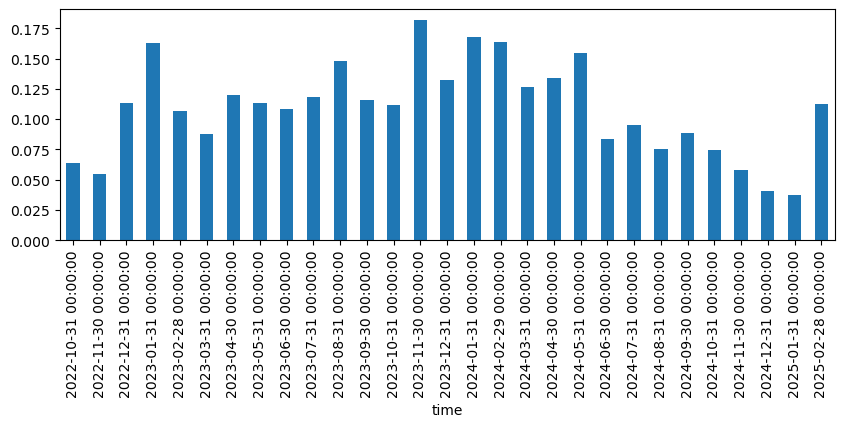

In [553]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/507087745.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

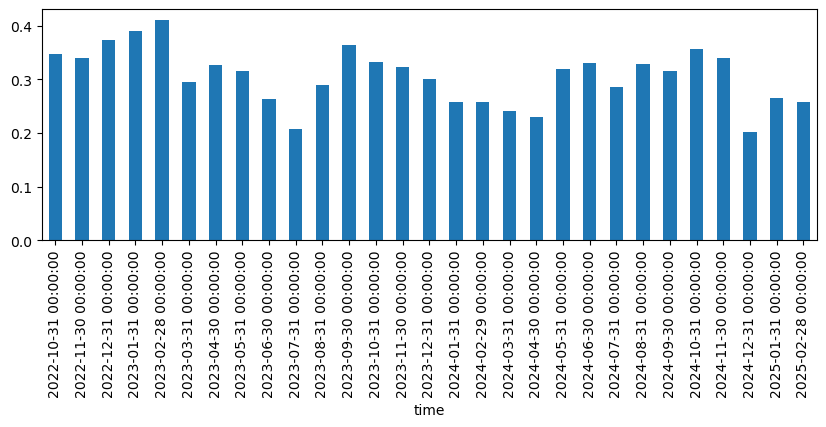

In [559]:
q = 0.99
col_target = 'target'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/7551147.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


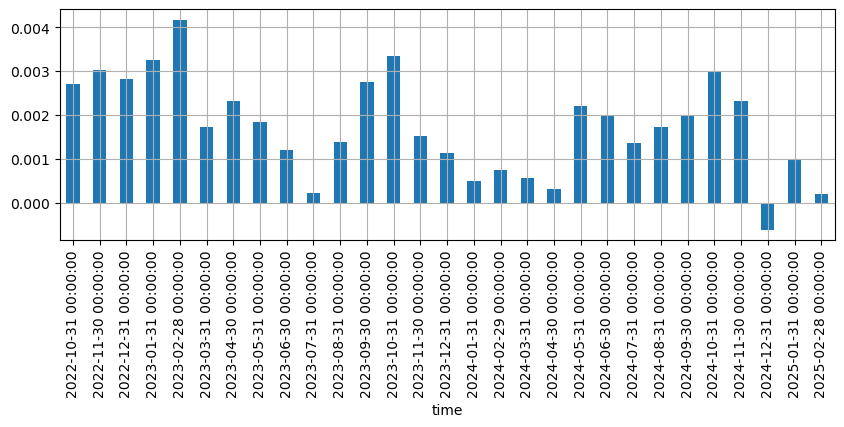

In [563]:
q = 0.99
col_target = 'income_rate'

mask_last_bin = df['y_pred'] > np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

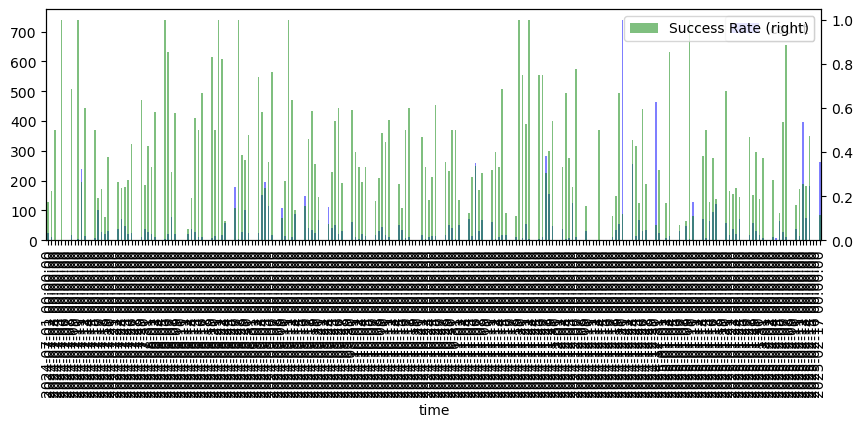

INCOME_RATE


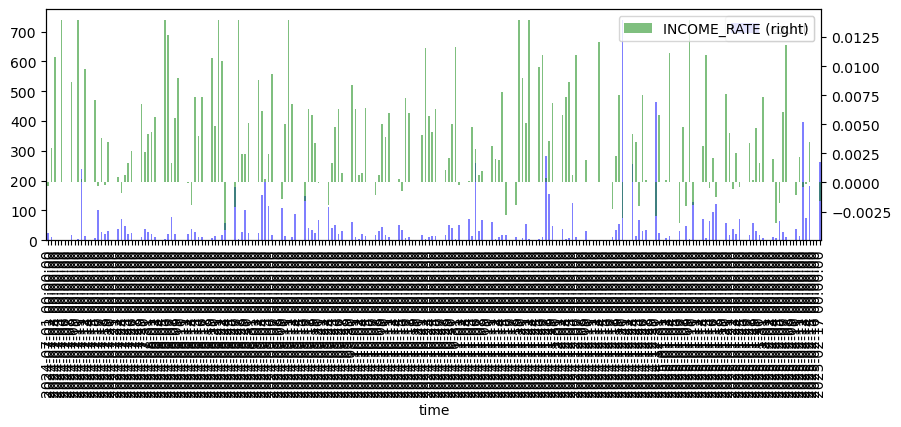

In [570]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [572]:
#y_test3

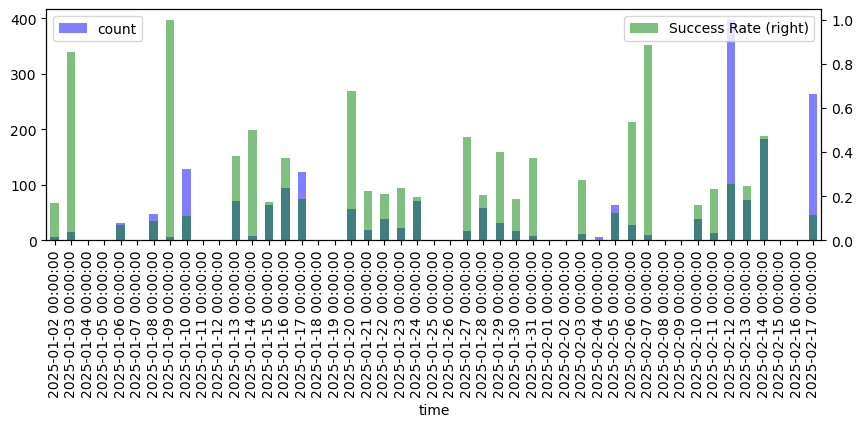

INCOME_RATE


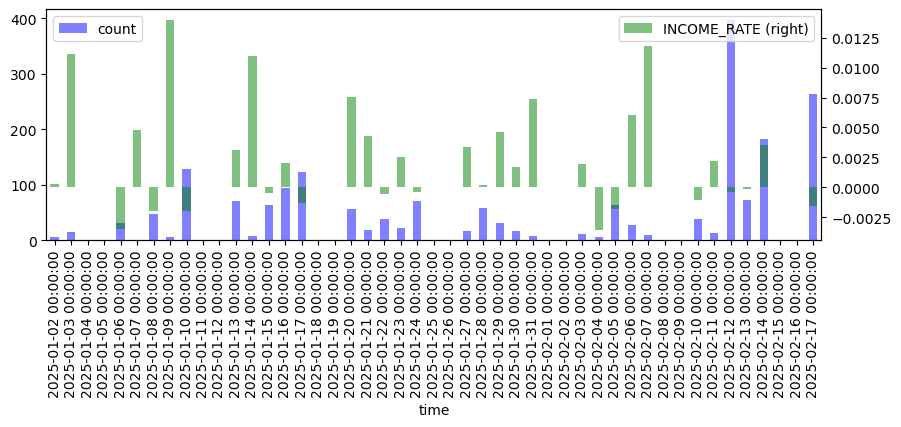

In [573]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.99
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [575]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.0051004444, 0.0041503864, 0.004128022)

In [576]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(43, 43, 39)

In [577]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)

In [580]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.10579606153898768, 0.09211790445260704, 0.08279805554640154)

In [586]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0025745432

In [589]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

33

In [591]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.05472191050648689

In [595]:
mask_data = mask_valid | mask_test | mask_test2

In [597]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0045081210136413575

In [600]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.006780627161957497

In [602]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0033836267715276675

In [604]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0032423642965463493

In [606]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


-3.2975818171645656e-05

#### Points in life

In [610]:
threshold

0.1640875613033059

In [612]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_50859/1532415291.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20     58
2025-01-21     20
2025-01-22     47
2025-01-23     26
2025-01-24     88
2025-01-25      0
2025-01-26      0
2025-01-27     18
2025-01-28     73
2025-01-29     30
2025-01-30     16
2025-01-31      8
2025-02-01      0
2025-02-02      0
2025-02-03     15
2025-02-04      6
2025-02-05     81
2025-02-06     31
2025-02-07      9
2025-02-08      0
2025-02-09      0
2025-02-10     48
2025-02-11     13
2025-02-12    544
2025-02-13     95
2025-02-14    194
2025-02-15      0
2025-02-16      0
2025-02-17    311
Freq: D, dtype: int64

### Обучить на всем

In [620]:
features_fe = ['close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w30_ma',
 'close/close_w10_expma',
 'close/close_w20_expma',
 'close/close_w30_expma']

cat_features = []

In [622]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [625]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [627]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 20}

In [629]:
model.num_trees()

20

In [631]:
del params['metric'], params['early_stopping']

In [637]:
params['num_boost_round'] = 20

In [639]:
model = lgbm.train(params, train_set=D_data)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [640]:
dump_pkl(model, 'model_+0.5_-1.5_4hour.pkl')

In [644]:
model = load_pkl('model_+0.5_-1.5_4hour.pkl')
model.num_trees()

20

In [646]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

0.6256296790664815

In [648]:
#0.6255231830367914

In [650]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5587011724339919

In [652]:
#0.54942855001115

In [655]:
THRESHOLD = 0.16409330252458745
THRESHOLD

0.16409330252458745

In [657]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0014111995697021484

In [659]:
#0.0015665830738791353

In [661]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.0026526456

In [663]:
#0.002858913740999845

In [665]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.057539140194523754

In [667]:
#0.061461629793354566

In [670]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0007231235504150391

In [672]:
#0.0013465678673751924

In [674]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026015062

In [676]:
#0.0032331111501514988

In [678]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.057233136147260666

In [680]:
#0.07112844530333297

In [683]:
# Получше, однако

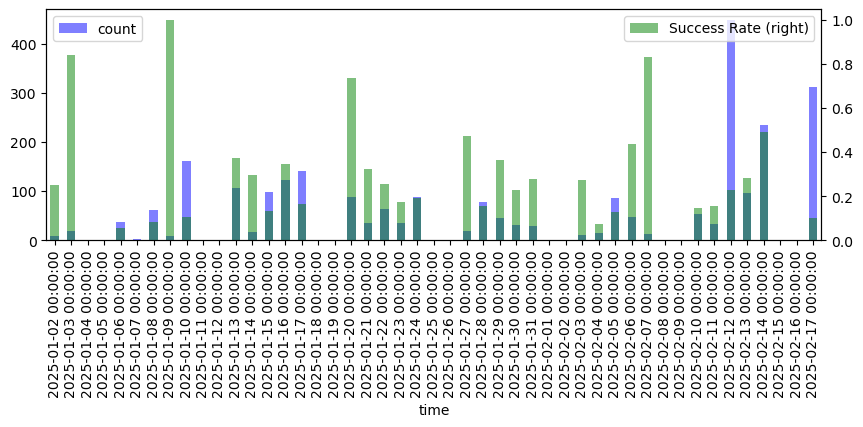

INCOME_RATE


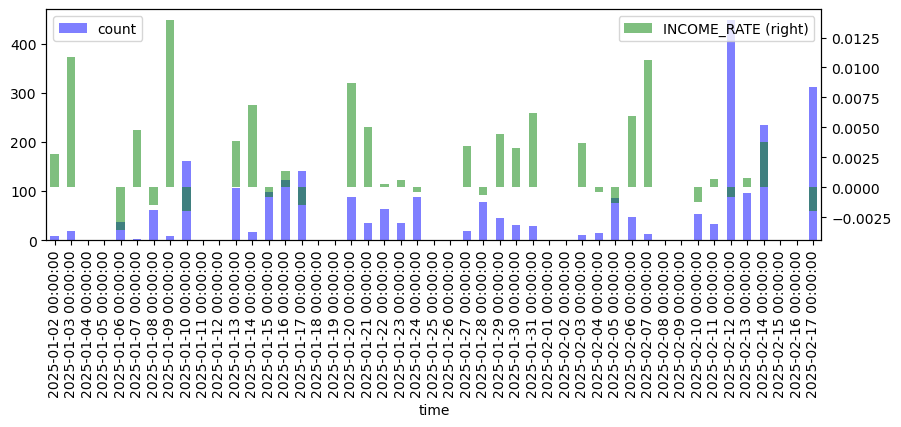

In [685]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [331]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w20_ma', 0.0),
 ('close/close_w10_expma', 6.17),
 ('close/close_w20_expma', 7.42),
 ('close/close_w30_ma', 11.94),
 ('close/close_w10_ma', 19.66),
 ('close/close_w30_expma', 54.81)]

In [ ]:
# [('close/close_w20_ma', 0.0),
#  ('close/close_w20_expma', 7.91),
#  ('close/close_w10_expma', 10.05),
#  ('close/close_w10_ma', 10.76),
#  ('close/close_w30_ma', 17.97),
#  ('close/close_w30_expma', 53.32)]